## DoSを分析するノートブック

In [101]:
using Plots
using DataFrames
using CSV
using StatsBase
using JLD2
using FileIO
using Combinatorics

### 出力結果の読み込みと設定

In [103]:
df = load("output/input/123/output.jld2")["results"]
M = length( names(df) ) - 4
num_states = 2^M
n = size(df[df.β.==1.0, :])[1]
B = unique(df.β)
T = length(B)
num_bins = 100
bottom = 1e-1

K = 5
num_states = sum([binomial(M,k) for k in 0:K])
# M

2621112

## マルチヒストグラム法によるDoSの推定

In [104]:
all_neg_log_likelihood = vec(Float64.(df.E))
hist = fit(Histogram, all_neg_log_likelihood, nbins=num_bins)

Histogram{Int64, 1, Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}
edges:
  -50.0:2.0:88.0
weights: [8836, 0, 6266, 3688, 3397, 18419, 1134, 19613, 30038, 0  …  263, 954, 2209, 3391, 307, 1630, 5658, 15481, 21745, 8691]
closed: left
isdensity: false

In [105]:
edges = Vector(hist.edges[1])
E = (edges[1:end-1] + edges[2:end]) ./ 2.0
H = hist.weights
tolerance = 1e-10
max_iter = 1000

Z = ones(T)
D = ones(length(H))
for i in 1:max_iter
    prev_Z = deepcopy(Z)

    D = vec( H ./ ( exp.( - E*B' ) * ( n ./ Z ) ) )
    Z = vec( D' * exp.( - E*B' ) )
    
    err = mean(abs.(Z .- prev_Z))
    if err < tolerance
        println("i=$i, err=$err")
        break
    end
end


i=251, err=2.9104288667963055e-11


### DoSの描画

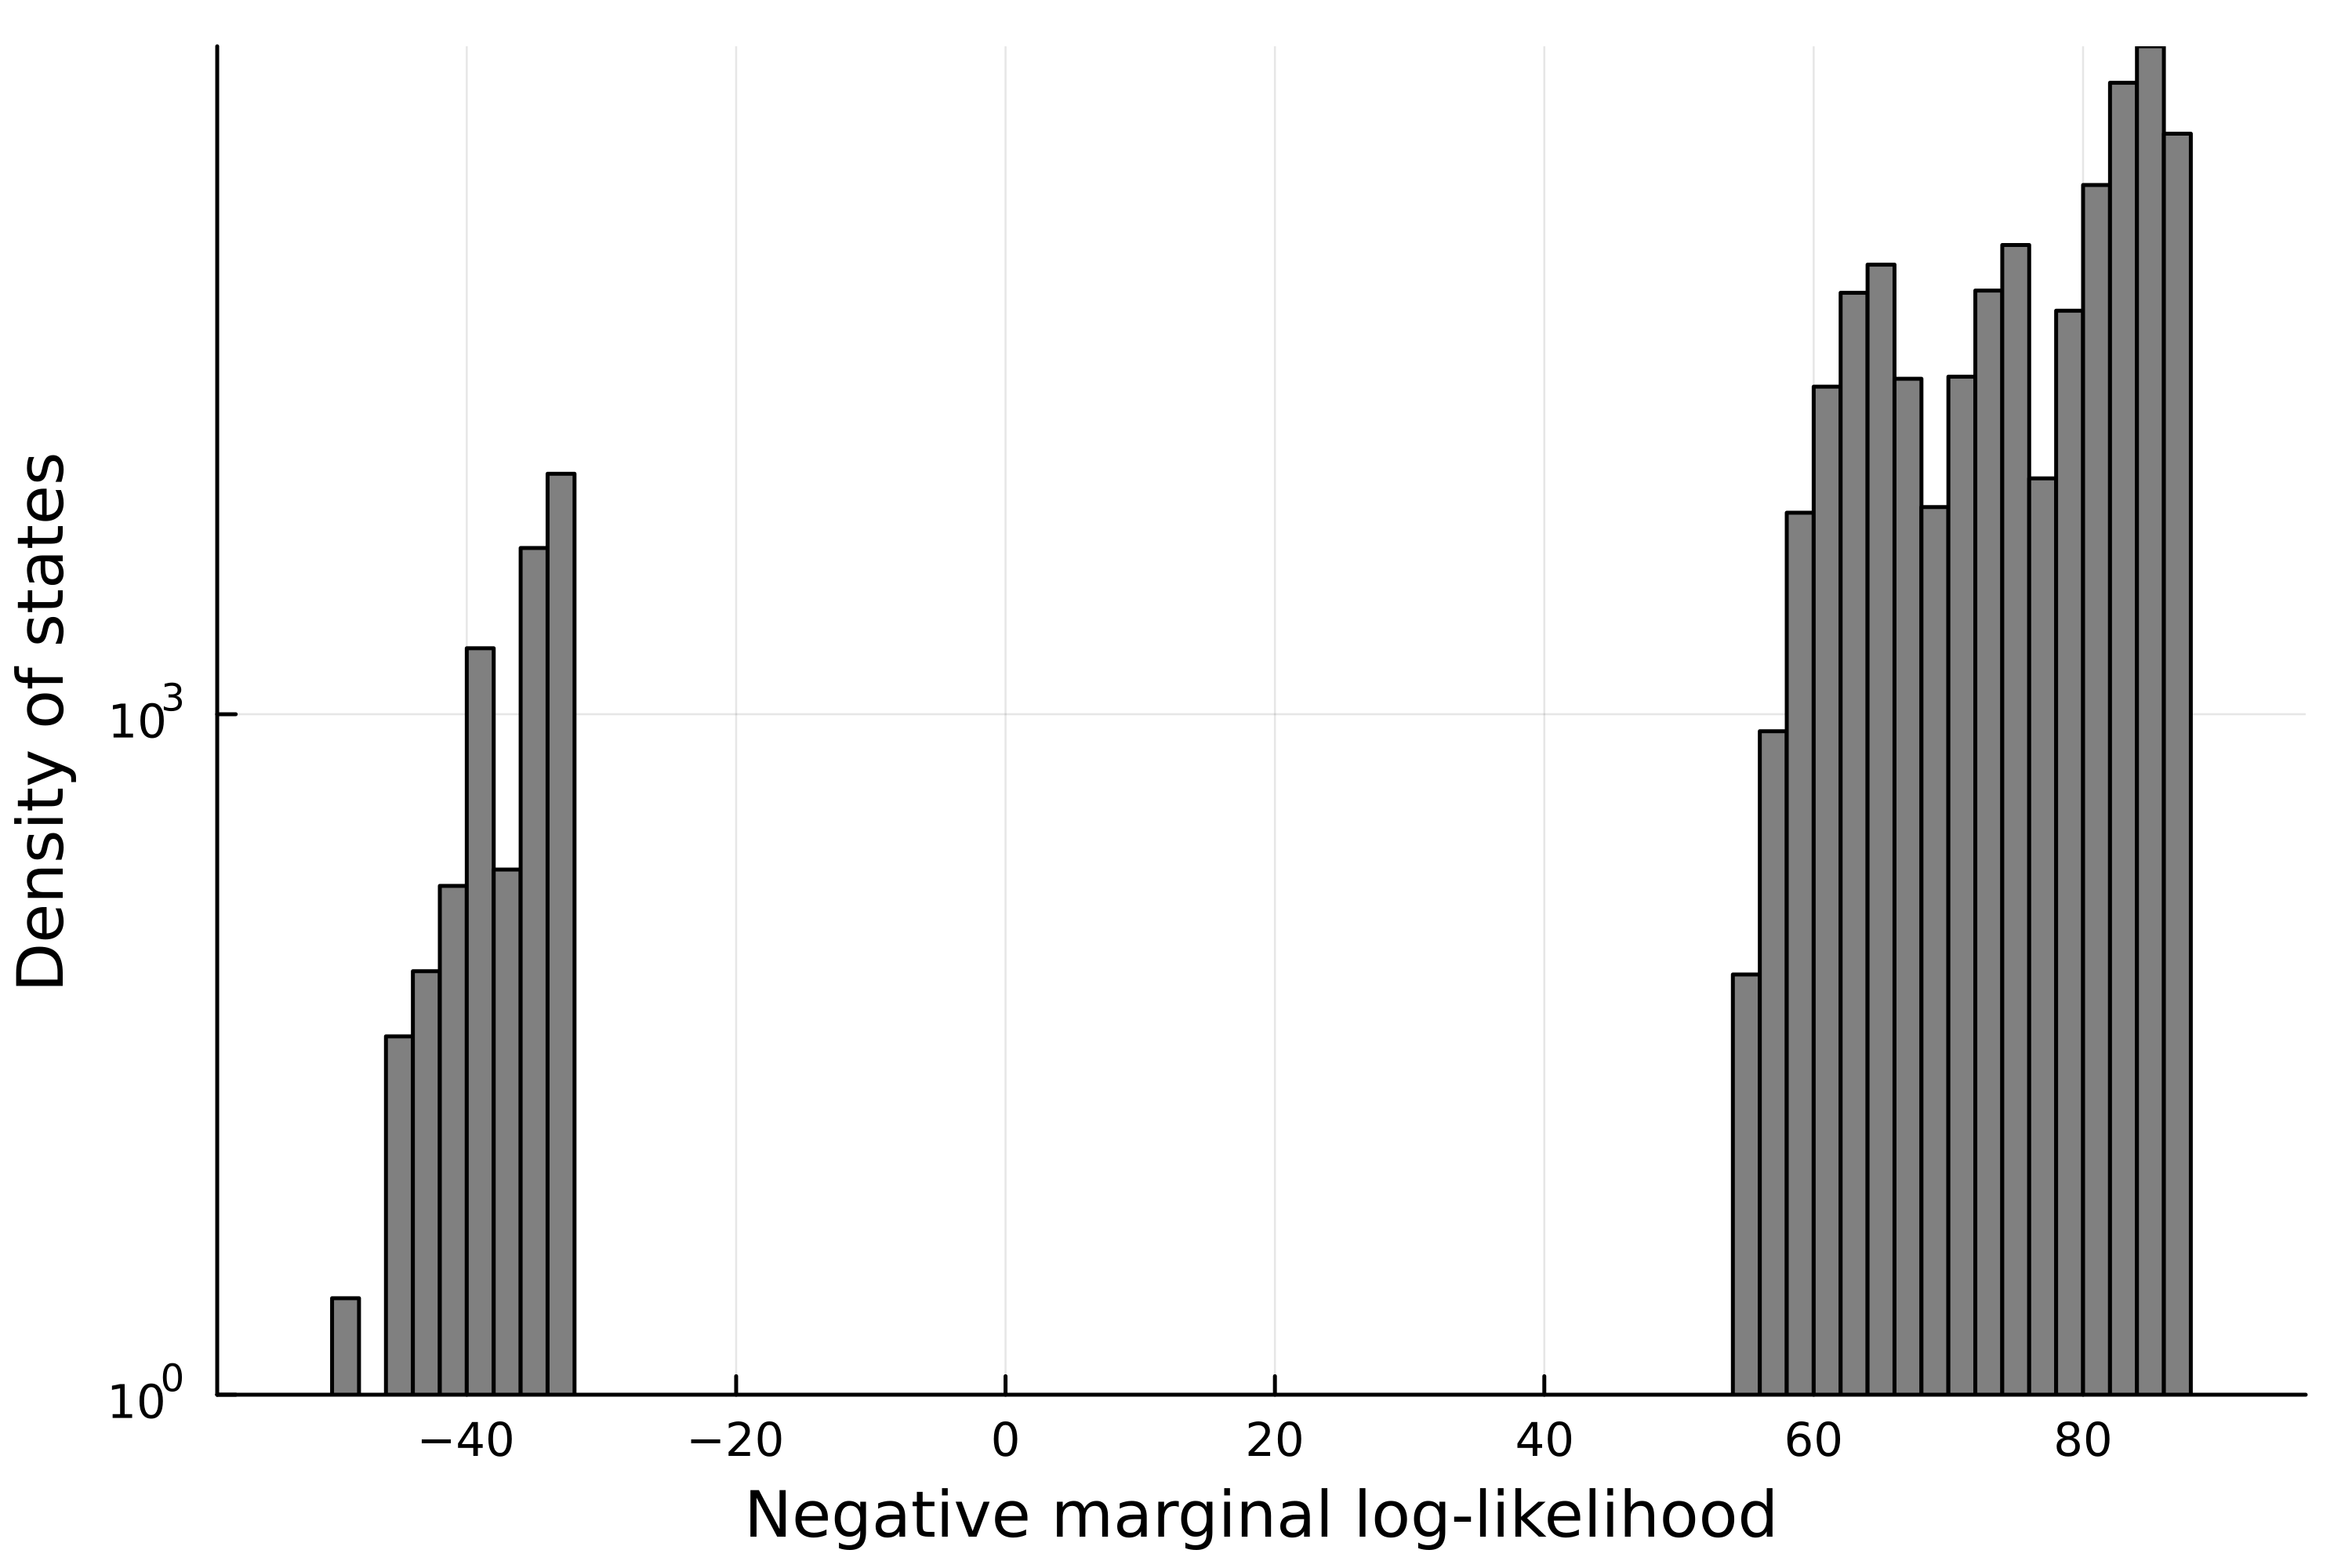

In [106]:
width = abs(E[1] - E[2])
plt = bar( E[D.!=0],  num_states .*( D[D.!=0] / sum(D[D.!=0]) ), legend=false,
xlabel="Negative marginal log-likelihood", ylabel = "Density of states",yscale=:log10, 
dpi=500, color="gray",  bar_width=width)

### DoSのサブセットの導出

In [107]:
pattern = r"0000000000000000000"
df_selected = df[occursin.(pattern, df.P), :]

histₛ = fit(Histogram, vec(Float64.(df_selected.E)), hist.edges[1])
Eₛ = (Vector(histₛ.edges[1])[1:end-1] + Vector(histₛ.edges[1])[2:end]) ./ 2.0
Hₛ = histₛ.weights
Dₛ = vec( Hₛ ./ ( exp.( - Eₛ*B' ) * ( n ./ Z ) ) )

( num_states .* ( Dₛ[Dₛ.!=0] / sum(D[D.!=0]) ) )'

1×25 adjoint(::Vector{Float64}) with eltype Float64:
 2.6637  38.0097  73.6334  168.739  …  3.15958e5  4.16308e5  1.55594e5

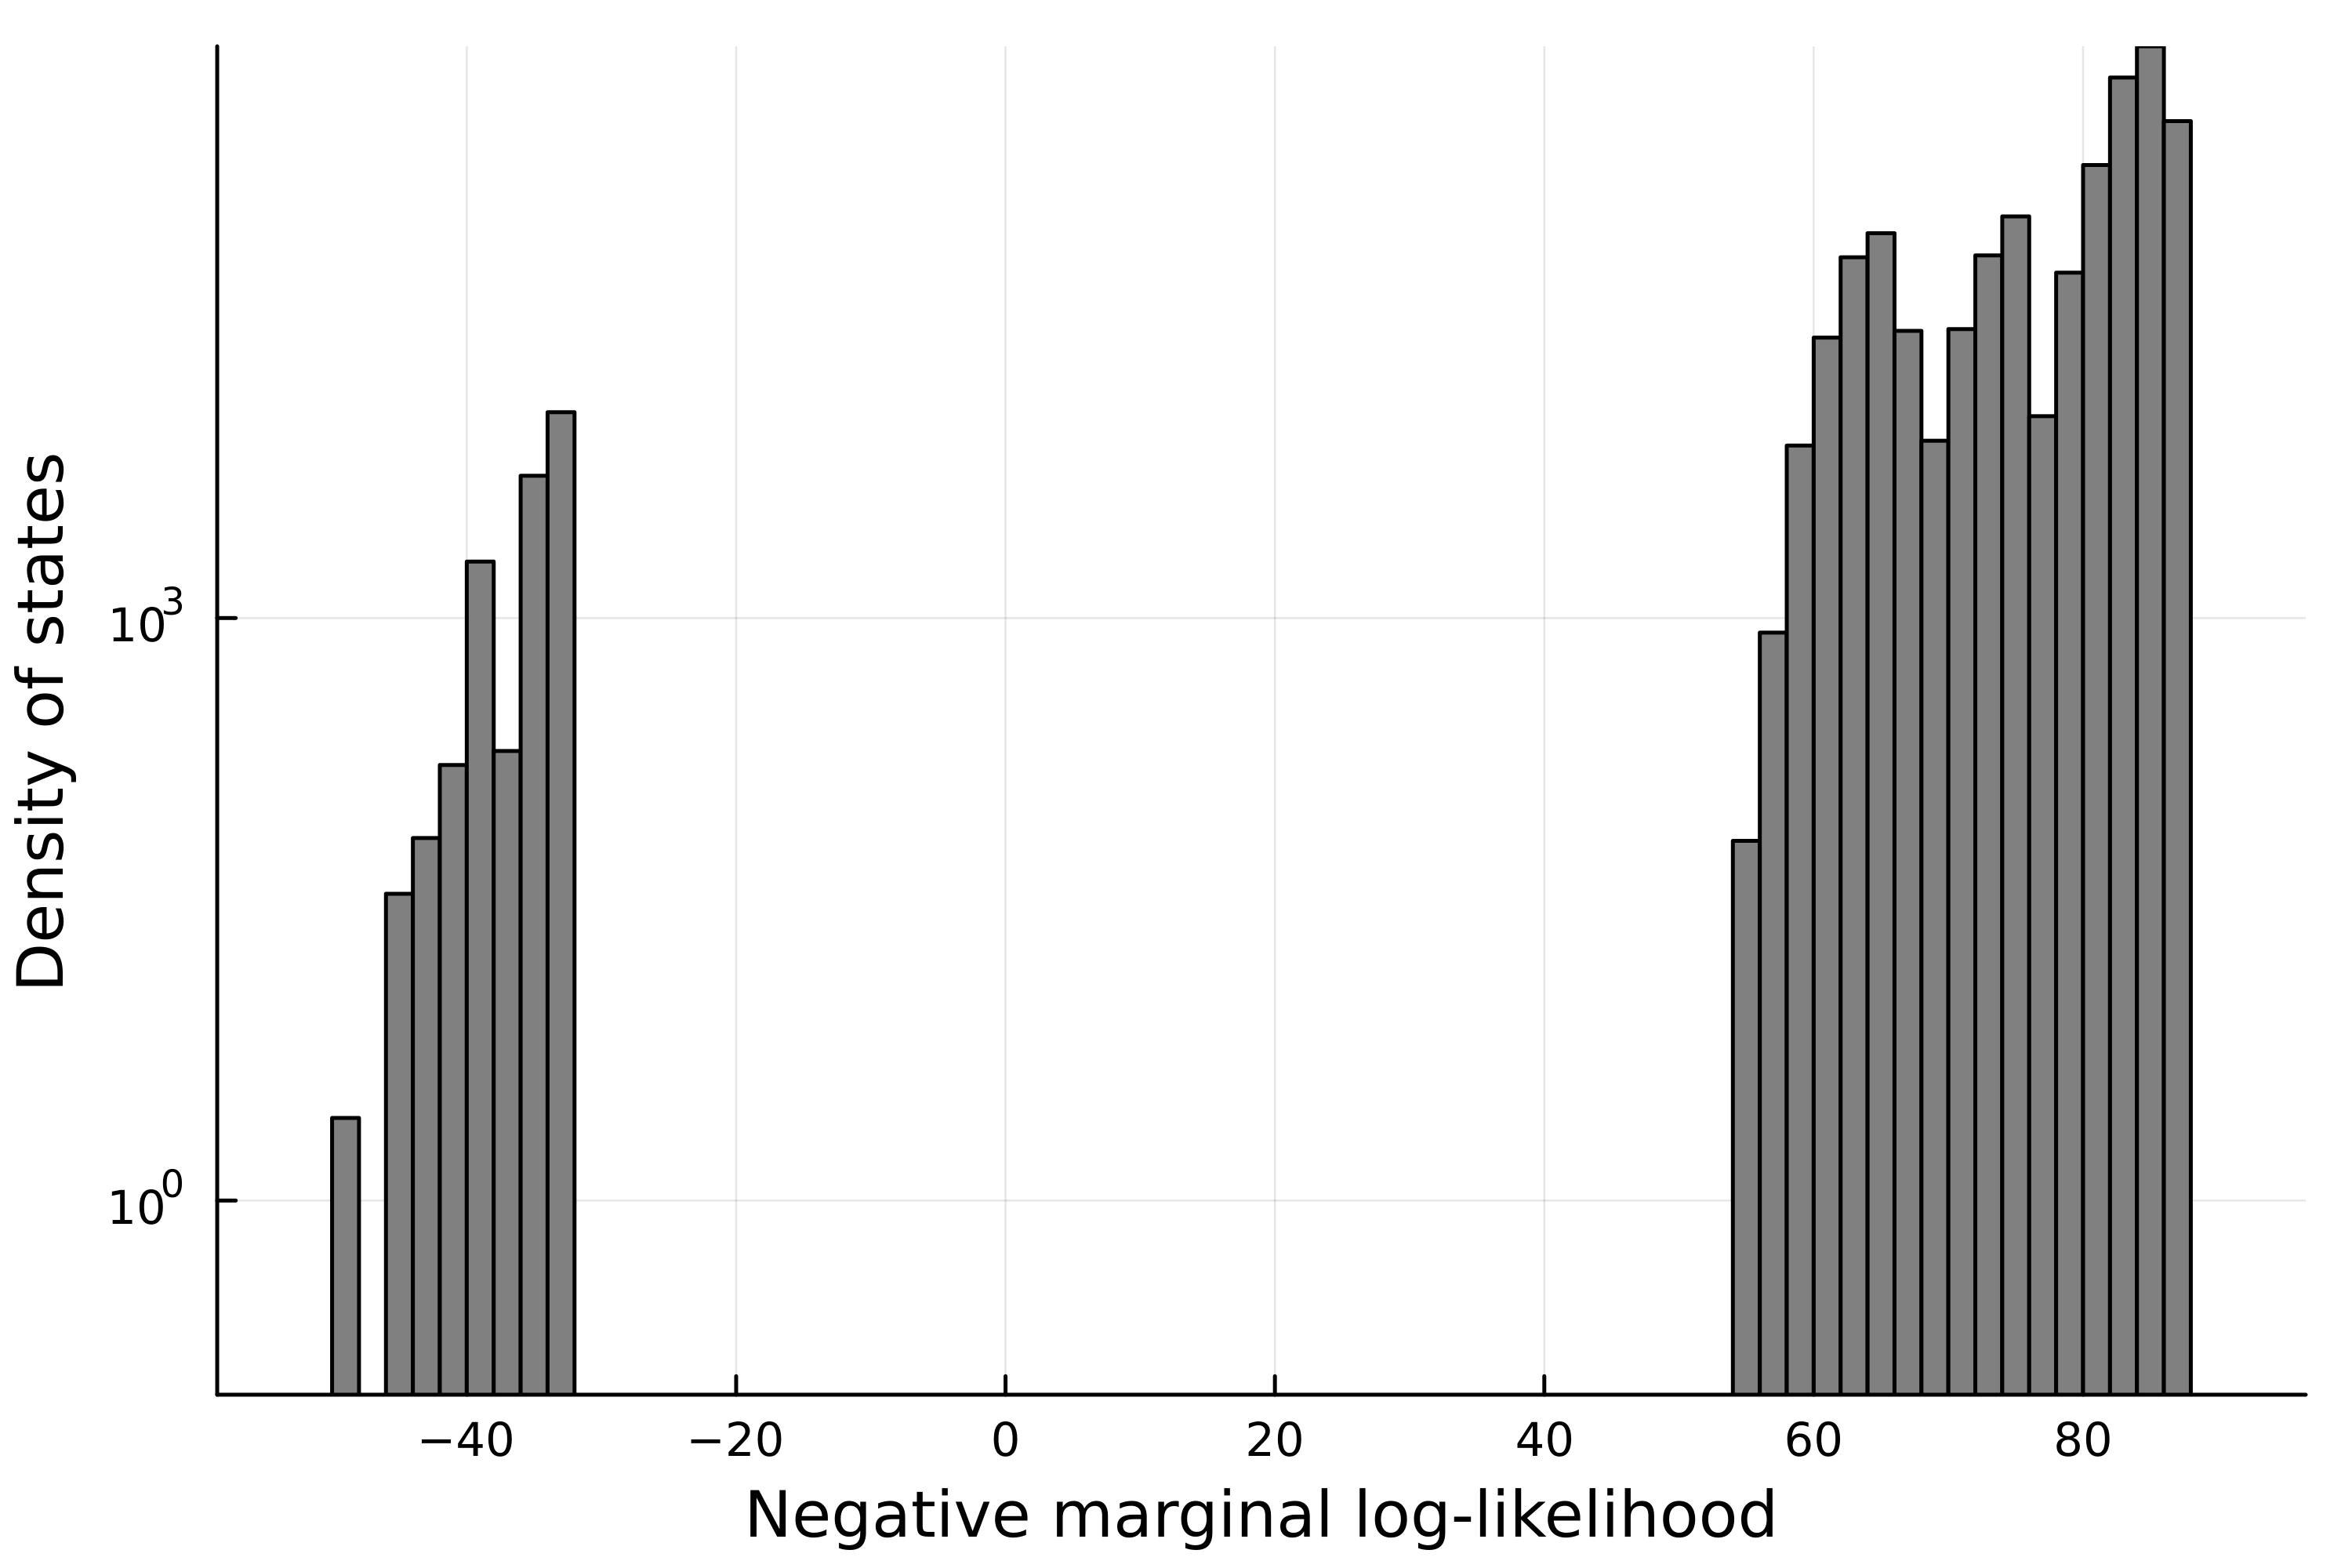

In [108]:

plot()
plt = bar( E[D.!=0],  num_states .*( D[D.!=0] / sum(D[D.!=0]) ), legend=false,
xlabel="Negative marginal log-likelihood", ylabel = "Density of states",yscale=:log10, 
dpi=500, color="gray",  bar_width=width, label="", fillrange=bottom)

# plt = bar!( Eₛ[Dₛ.!=0], num_states .* ( Dₛ[Dₛ.!=0] / sum(D[D.!=0]) ), legend=true,
# xlabel="Negative marginal log-likelihood", ylabel = "Density of states",# yscale=:log10,
# dpi=500, color="blue",  bar_width=width, label=pattern)

### DoSのクラス分け

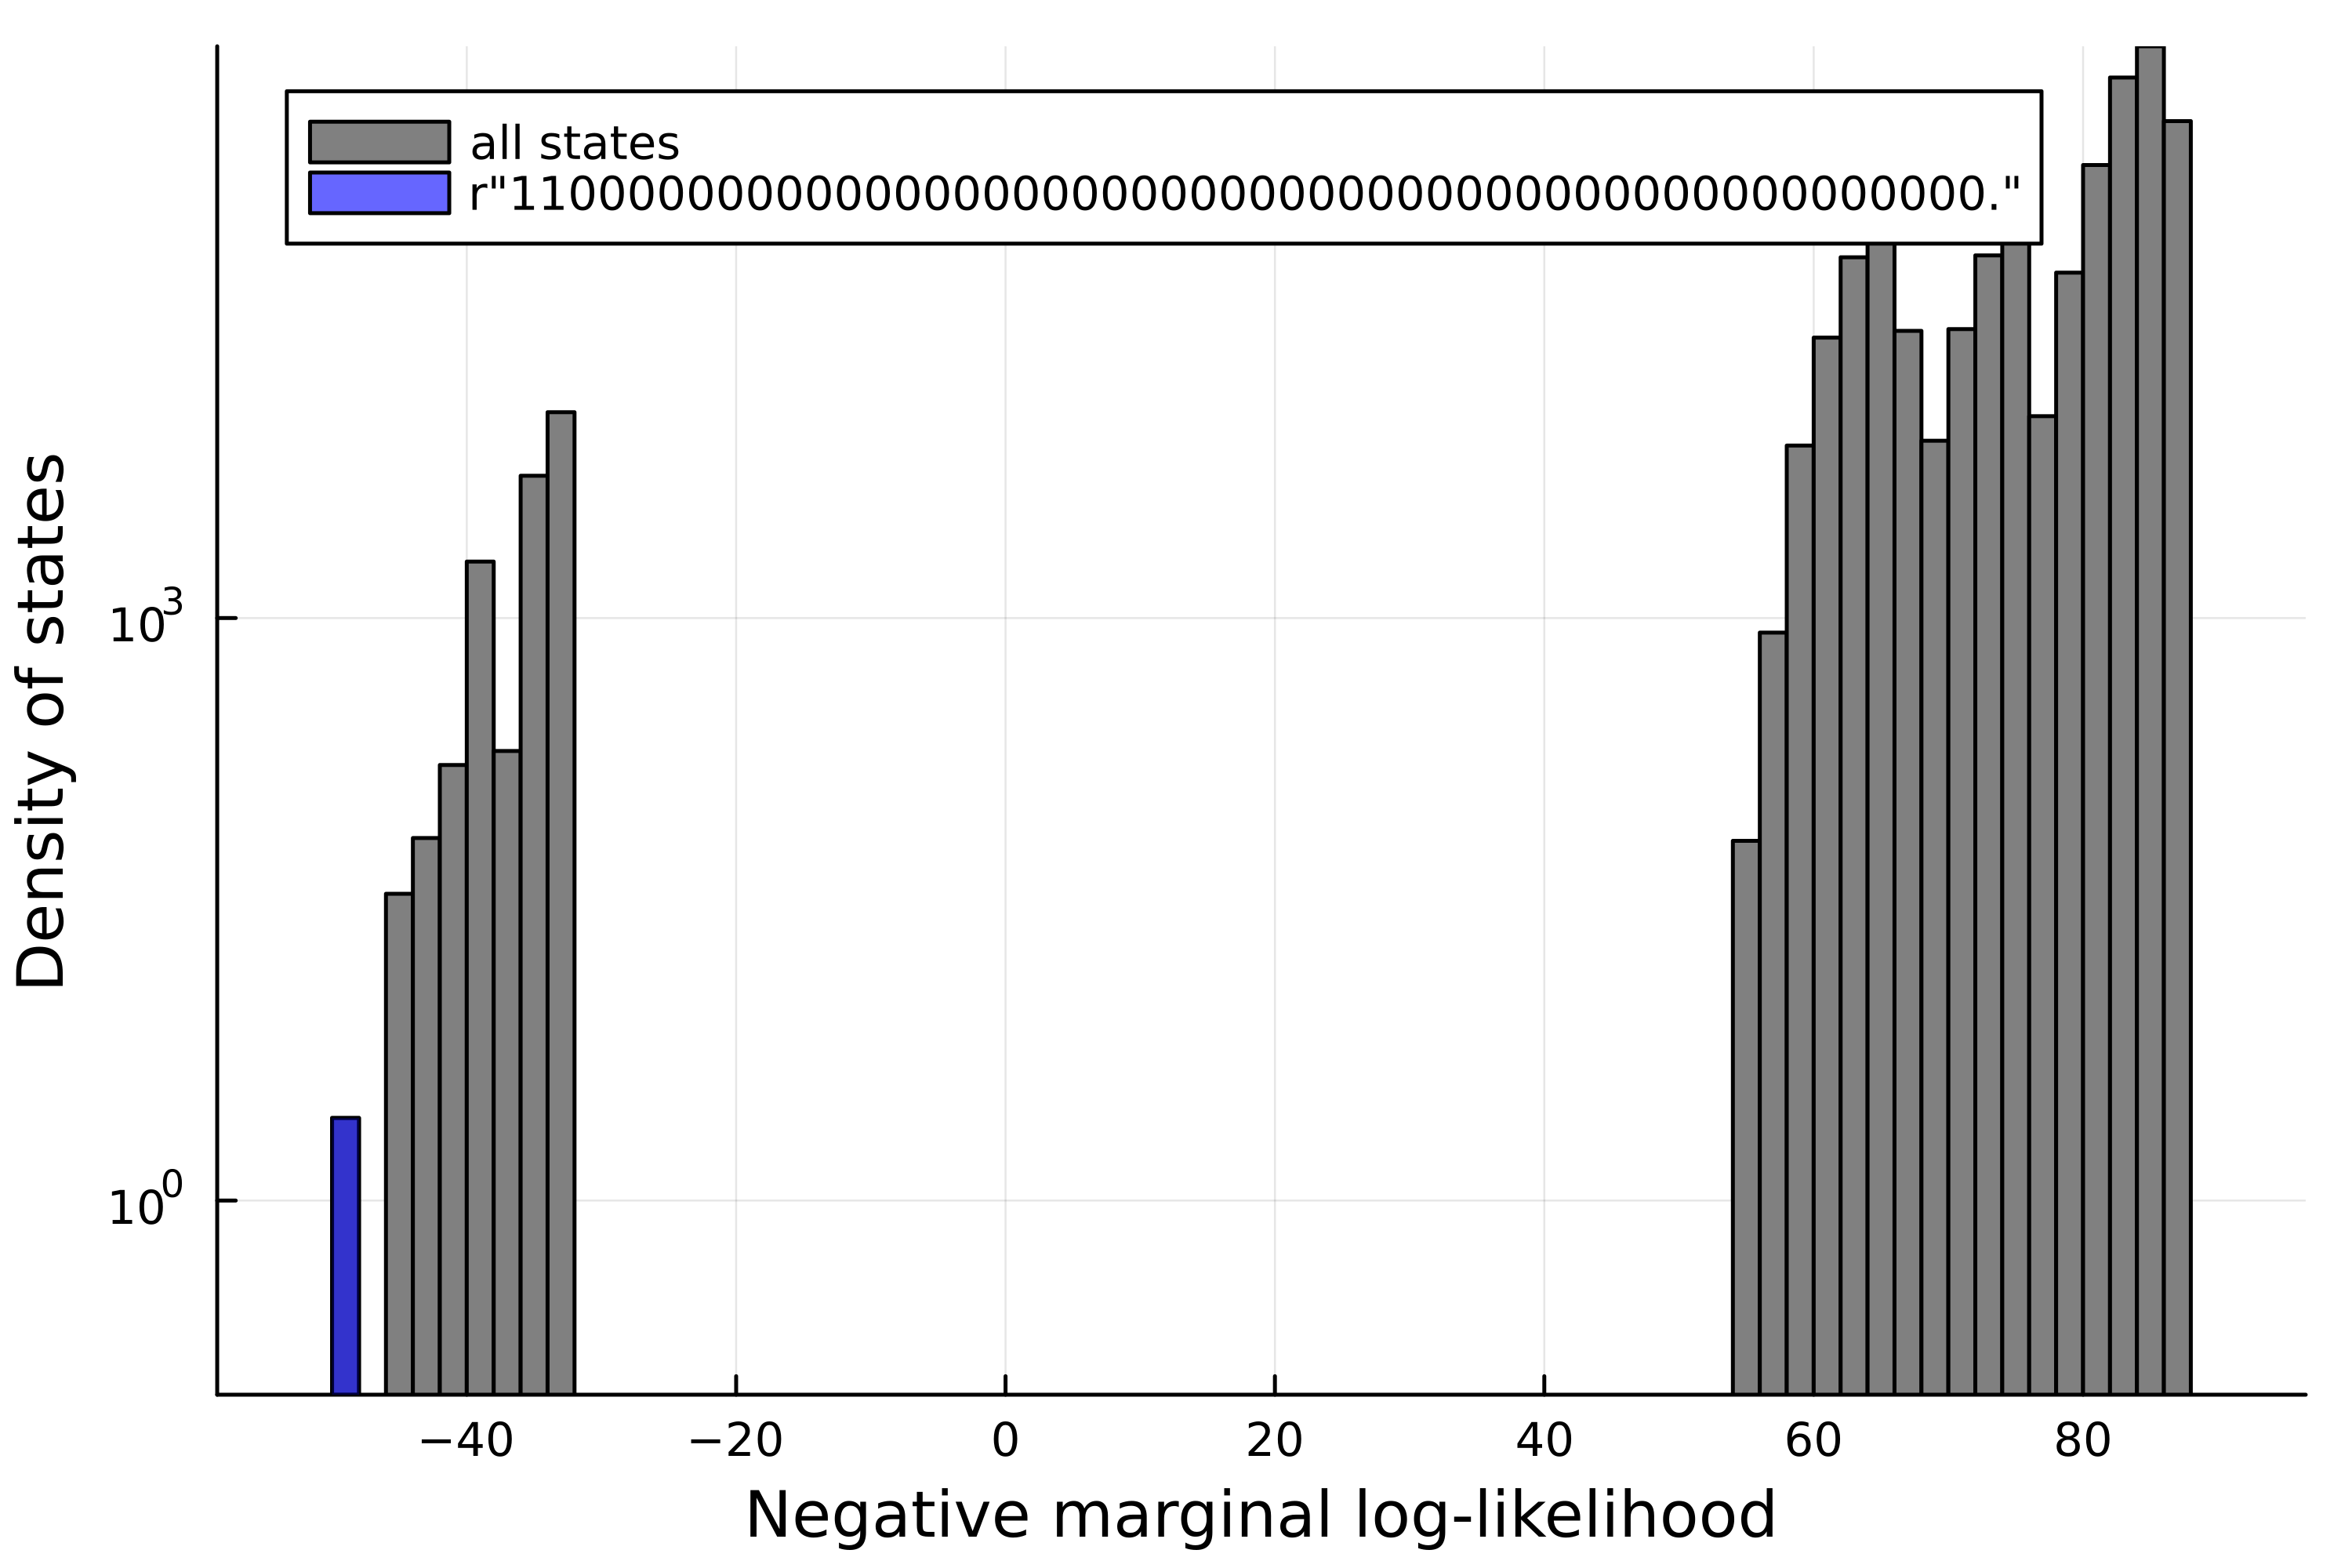

In [113]:

### --------------------------------------------------------------------------------------------------------
plt = bar( E[D.!=0],  num_states .*( D[D.!=0] / sum(D[D.!=0]) ), legend=false,
xlabel="Negative marginal log-likelihood", ylabel = "Density of states", yscale=:log10, 
dpi=500, color="gray",  bar_width=width, label="all states", fillrange=bottom# , xlim=(-70, 110)
)



### --------------------------------------------------------------------------------------------------------
# p_i = r"............1....11"
# p_i = r"............0......"
# p_i = r"............1....11"
# c_i = "red"
# df_selected = df[occursin.(p_i, df.P), :]
# df_selected = df[( (df.K .< 4) .& occursin.(p_i, df.P) ), :]
# histₛ = fit(Histogram, vec(Float64.(df_selected.E)), hist.edges[1])
# Eₛ = (Vector(histₛ.edges[1])[1:end-1] + Vector(histₛ.edges[1])[2:end]) ./ 2.0
# Hₛ = histₛ.weights
# Dₛ = vec( Hₛ ./ ( exp.( - Eₛ*B' ) * ( n ./ Z ) ) )
# plt = bar!( Eₛ[Dₛ.!=0], num_states .* ( Dₛ[Dₛ.!=0] / sum(D[D.!=0]) ), legend=true,
#                     xlabel="Negative marginal log-likelihood", ylabel = "Density of states", 
#                     yscale=:log10,dpi=500, color=c_i, bar_width=width,
#                     label=p_i, alpha=0.6, fillrange=bottom)



# ### --------------------------------------------------------------------------------------------------------
# p_i = "11" * repeat(".", M-2)
# p_i = repeat(".", M)
p_i = r"11000000000000000000000000000000000000000000000000."
c_i = "blue"
df_selected = df[occursin.(p_i, df.P), :]
# df_selected = df[( (df.K .<= 5) .& occursin.(p_i, df.P) ), :]
histₛ = fit(Histogram, vec(Float64.(df_selected.E)), hist.edges[1])
Eₛ = (Vector(histₛ.edges[1])[1:end-1] + Vector(histₛ.edges[1])[2:end]) ./ 2.0
Hₛ = histₛ.weights
Dₛ = vec( Hₛ ./ ( exp.( - Eₛ*B' ) * ( n ./ Z ) ) )
plt = bar!( Eₛ[Dₛ.!=0], num_states .* ( Dₛ[Dₛ.!=0] / sum(D[D.!=0]) ), legend=true,
                    xlabel="Negative marginal log-likelihood", ylabel = "Density of states",
                    yscale=:log10, dpi=500, color=c_i, bar_width=width,
                    label=p_i, alpha=0.6, fillrange=bottom)



### --------------------------------------------------------------------------------------------------------
# p_i = "K==2"
# c_i = "green"
# df_selected = df[df.K.==4, :]
# histₛ = fit(Histogram, vec(Float64.(df_selected.E)), hist.edges[1])
# Eₛ = (Vector(histₛ.edges[1])[1:end-1] + Vector(histₛ.edges[1])[2:end]) ./ 2.0
# Hₛ = histₛ.weights
# Dₛ = vec( Hₛ ./ ( exp.( - Eₛ*B' ) * ( n ./ Z ) ) )
# plt = bar!( Eₛ[Dₛ.!=0], num_states .* ( Dₛ[Dₛ.!=0] / sum(D[D.!=0]) ), legend=true,
#                     xlabel="Negative marginal log-likelihood", ylabel = "Density of states", yscale=:log10,
#                     dpi=500, color=c_i, bar_width=width,
#                     label=p_i, alpha=0.8, fillrange=bottom)

# savefig(plt, "DoS.png")

In [112]:
"11" * repeat("0", M-2)

"110000000000000000000000000000000000000000000000000"

In [114]:
num_states .* ( Dₛ[Dₛ.!=0] / sum(D[D.!=0]) )

1-element Vector{Float64}:
 2.6636976253822966